# Incorporating Empirical Nonlinear Efficiency Into Control Co-Optimization of Real World Heaving Point Absorber Using Wecopttool
Daniel T. **Gaebele**, Carlos A. **Michelén Ströfer**, Michael C. **Devin**, Jeff, T. **Grasberger**, Ryan G. **Coe**, and Giorgio **Bacelli** 

## OMAE2023-103899
42nd International Conference on Ocean, Offshore and Arctic Engineering (OMAE2023),
June 11– 16, 2023, Melbourne, Australia


In [1]:
import logging
# from datetime import datetime
import pygmsh
import gmsh
import wecopttool as wot
import capytaine as cpy
import autograd.numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

from scipy.optimize import brute

logging.basicConfig(level=logging.ERROR)

# 2 OPTIMIZATION PROBLEM

In [2]:
g = 9.81
rho = 1025

### Frequencies

In [3]:
f1 = 0.04
nfreq = 25
freq = wot.frequency(f1, nfreq, False) # False -> no zero frequency

### AH WEC

In [4]:
T1, T2, T3=1.5, 0.355, 7.25
r1, r2, r3 = 1.085, 0.405, 0.355
ofst=0.1

with pygmsh.occ.Geometry() as geom:
    gmsh.option.setNumber('Mesh.MeshSizeFactor', 0.4)
    cyl1 = geom.add_cylinder([0,0,0], [0,0,-T1], r1)
    cone = geom.add_cone([0,0,-T1], [0,0,-T2], r1, r2)
    cylout = geom.add_cylinder([0,0,-1*(T1+T2)], [0,0,-T3], r2)
    cylin = geom.add_cylinder([0,0,-1*(T1+T2)], [0,0,-T3],  r3)
    cyl2 = geom.boolean_difference(cylout,cylin)[0]
    wecGeom = geom.boolean_union(entities=[cyl1, cone, cyl2],
                                    delete_first=True)[0]
    geom.translate(wecGeom, [0, 0, ofst])
    mesh = geom.generate_mesh()

fb = cpy.FloatingBody.from_meshio(mesh, name="AH_WEC")
fb.add_translation_dof(name="Heave")
ndof = fb.nb_dofs

In [5]:
mass = np.atleast_2d(3000) # [kg] assume inital mass
displaced_mass_cpy = wot.hydrostatics.inertia_matrix(fb).values
displacement = displaced_mass_cpy/rho # [m^3] disp. vol w. ballast and pretension

(-0.054250000000000236, 1.1392499999999999, -9.56525, 0.56025)

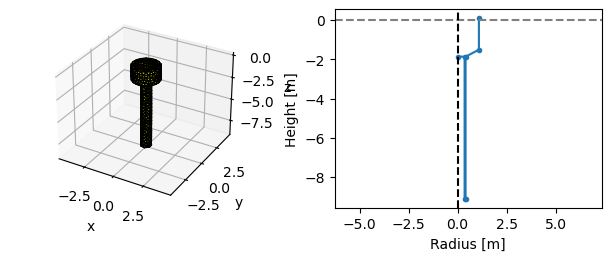

In [6]:
#FIGURE 3
fig, axes = plt.subplots(ncols=2,
                       figsize=(6,2.5), sharex = False,
                       constrained_layout=True)
axes[0].axis('off')
axes[0] = fig.add_subplot(1, 2, 1, projection=Axes3D.name)
fb.show_matplotlib(ax = axes[0])
axes[1].plot(
    [0, r3, r3, r2, r2, r1, r1],    
    [-1*(T1+T2), -1*(T1+T2),  -1*(T1+T2+T3), -1*(T1+T2+T3), -1*(T1+T2),
        -1*(T1), ofst],
    marker='.')

axes[1].set_xlim(left=0)
axes[1].axhline(0, color='grey', linestyle='--')
axes[1].axvline(0, color='k', linestyle='--')
axes[1].set_xlabel('Radius [m]')
axes[1].set_ylabel('Height [m]')
axes[1].axis('equal')

## 2.1 WEC Dynamics

In [7]:
stiffness = wot.hydrostatics.stiffness_matrix(fb).values
bem_data = wot.run_bem(fb, freq)
wec = wot.WEC.from_bem(
    bem_data,
    inertia_matrix=mass,
    hydrostatic_stiffness=stiffness,
    constraints=None,
    friction=None,
    f_add=None,
)
# mooring line constraint
min_line_tension = -1000    #[N]
max_line_tension = -500000  #[N]

### PTO parameters

In [8]:
radii = {"S1": 0.02, "S2": 0.795, "S3":0.1595, 
         "S4":0.200525, "S5":0.40105, "S6":0.12575, "S7":0.103}
inertias = {"Igen":3.9, "I1":0.029, "I2":25.6, "I3":1.43, 
         "I4":1.165, "I5":4.99, "I6":1.43, "I7":1.5, "mps":40}
friction = {"Bgen":7, "Bdrivetrain":40, "Bshaft":40,
            "Bspring_pulley":80, "Bpneumatic_spring":700, 
            "Bpneumatic_spring_static1":0, 
            "Bpspneumatic_spring_static2":0}
airspring = {"gamma":1.4, "height":1, "diameter":3, 
             "area":0.0709676, "press_init": 854e3, "vol_init":1}

In [9]:
gear_ratios = {"R21":radii['S2']/radii['S1'],
               "R45":radii['S4']/radii['S5'], 
               "R67":radii['S6']/radii['S7'],
               "spring":radii['S6']*(radii['S4']/radii['S5'])}
inertia_PTO = ((inertias["Igen"]  + inertias["I1"])*gear_ratios['R21']**2 +
               (inertias['I2'] +inertias['I3'] + inertias['I4']) +
                ((inertias['I5'] + inertias['I6']) +
                 inertias["I7"] * gear_ratios['R67']**2 +
                 inertias['mps'] * radii['S6']**2   
                )*gear_ratios["R45"]**2
               )
friction_PTO = (friction['Bgen']*gear_ratios['R21']**2 + 
                friction['Bdrivetrain'] +
                  (friction["Bshaft"]+
                  friction["Bspring_pulley"]*gear_ratios['R67']**2 +
                  friction["Bpneumatic_spring"]*radii['S6']**2
                  )*gear_ratios["R45"]**2
               )

## 2.2 Generator model

In [10]:
gear_ratio_generator = gear_ratios['R21']/radii['S3']
kinematics = gear_ratio_generator*np.eye(ndof)  #Eq. (12)

In [11]:
def Ploss_interp(flow, effort):
    #Ploss fit Eq. (18)
    # using only first quadrant, but assuming perfect symmetry (piecewise continous)
    eff_max = 300
    flow_max = 10000*2*np.pi/60
  
    k01 =      0.0068  
    k03 =    0.001226  
    k10 =     0.00939  
    k20 =   0.0003282  
    k21 =     0.04731  
    k40 =     0.01486  

    Ploss = [(k01*flo + k03*flo**3 
              +k10*eff + k20*eff**2 
              +k40*eff**4 + k21*flo*eff**2) * eff_max*flow_max
            for eff,flo in
             zip(np.abs(effort)/eff_max,np.abs(flow)/flow_max) ]
    Ploss = np.array(Ploss)
    return Ploss 

In [12]:
def constant_Ploss_interp(flow, effort): 
    #Pelec fit with R^2: 0.9991
    #turn constant efficiency coefficient into loss map
    eff_max = 300
    flow_max = 10000*2*np.pi/60
    eta =       0.925 

    Ploss = [(((1-eta)/eta)*eff*flo)*eff_max*flow_max 
                for eff,flo 
                in zip(np.abs(effort)/eff_max,np.abs(flow)/flow_max)]
    Ploss =  np.array(Ploss)
    return Ploss

In [13]:
# Generator constraints
torque_peak_max = 280    #[Nm]   
torque_continues_max = 120 #[Nm]
rot_speed_max = 10000*2*np.pi/60    #[rad/s]
power_max = 80000   #[W]


# 3 OPTIMAL CONTROL TRACJECTORIES

In [14]:
#define waves
amplitude_1 = 0.25
amplitude_2 = 1.25

wavefreq =  0.12  
phase = 30
wavedir = 0

waves_A1 = wot.waves.regular_wave(f1, nfreq, wavefreq, amplitude = amplitude_1, phase = phase, direction = wavedir)
waves_A2 = wot.waves.regular_wave(f1, nfreq, wavefreq, amplitude = amplitude_2, phase = phase, direction = wavedir)

In [15]:
def solve_wrapper_function(wec, pto, nstate_opt, scale_x_wec, scale_x_opt, scale_obj, waves):
    #define forces Eq. (3)-(7)
    def F_buoyancy(wec, x_wec, x_opt, waves, nsubsteps = 1):
        """Only the zero-th order component (doesn't include linear stiffness"""
        return displacement * rho * g * np.ones([wec.ncomponents*nsubsteps, wec.ndof])
    def F_gravity(wec, x_wec, x_opt, waves, nsubsteps = 1):
        return -1 * wec.inertia_matrix.item() * g * np.ones([wec.ncomponents*nsubsteps, wec.ndof])
    def F_pretension_wec(wec, x_wec, x_opt, waves, nsubsteps = 1):
        """Pretension force as it acts on the WEC"""
        F_b = F_buoyancy(wec, x_wec, x_opt, waves, nsubsteps) 
        F_g = F_gravity(wec, x_wec, x_opt, waves, nsubsteps)
        return  -1*(F_b+F_g)
    def F_pto_line(wec, x_wec, x_opt, waves, nsubsteps = 1):
        f_pto = pto.force_on_wec(wec, x_wec, x_opt, waves, nsubsteps)
        f_pre = F_pretension_wec(wec, x_wec, x_opt, waves, nsubsteps)
        return f_pto + f_pre
    def F_pto_ifs(wec, x_wec, x_opt, waves, nsubsteps = 1):
        pos = wec.vec_to_dofmat(x_wec)
        vel = np.dot(wec.derivative_mat,pos)
        acc = np.dot(wec.derivative_mat, vel)
        time_matrix = wec.time_mat_nsubsteps(nsubsteps)
        spring = -(gear_ratios['spring']*airspring['gamma']*airspring['area']*
                airspring['press_init']/airspring['vol_init']) * pos
        F_spring = np.dot(time_matrix,spring)
        fric = -(friction_PTO  + 
                    friction['Bpneumatic_spring_static1']*
                    gear_ratios['spring']) * vel
        F_fric = np.dot(time_matrix,fric)
        inertia = inertia_PTO * acc
        F_inertia = np.dot(time_matrix,inertia)
        return (F_spring + F_fric + F_inertia)

    wec.forces['buoyancy'] = F_buoyancy
    wec.forces['gravity'] = F_gravity
    wec.forces['PTO'] = F_pto_line
    wec.forces['PTO_ifs'] = F_pto_ifs

    #define constraints Eq. (21)-(27)
    nsubsteps = 5
    def const_peak_torque_pto(wec, x_wec, x_opt, waves): # Format for scipy.optimize.minimize
        """Instantaneous torque must not exceed max torque 
            Tmax - |T| >=0 """
        torque = pto.force(wec, x_wec, x_opt, waves, nsubsteps)
        return torque_peak_max - np.abs(torque.flatten())
    def const_torque_pto(wec, x_wec, x_opt, waves): 
        """RMS torque must not exceed max continous torque 
            Tmax_conti - Trms >=0 """
        torque_rms = np.sqrt(np.mean(pto.force(wec, 
                                               x_wec, 
                                               x_opt, 
                                               waves, nsubsteps)**2))
        return torque_continues_max - np.abs(torque_rms.flatten())
    def const_speed_pto(wec, x_wec, x_opt, waves): 
        rot_vel = pto.velocity(wec, x_wec, x_opt, waves, nsubsteps)
        return rot_speed_max - np.abs(rot_vel.flatten())
    def const_power_pto(wec, x_wec, x_opt, waves): 
        power_mech = (pto.velocity(wec, x_wec, x_opt, waves, nsubsteps) *
                        pto.force(wec, x_wec, x_opt, waves, nsubsteps))
        return power_max - np.abs(power_mech.flatten())
    def constrain_min_tension(wec, x_wec, x_opt, waves):
        total_tension = -1*F_pto_line(wec, x_wec, x_opt, waves, nsubsteps)
        return total_tension.flatten() + min_line_tension
    def constrain_max_tension(wec, x_wec, x_opt, waves):
        total_tension = 1*F_pto_line(wec, x_wec, x_opt, waves, nsubsteps)
        return total_tension.flatten() - max_line_tension
    def zero_mean_pos(wec, x_wec, x_opt, waves):
        return x_wec[0]

    constraints = [{'type': 'ineq',
                'fun': const_peak_torque_pto},
            {'type': 'ineq',
                'fun': const_torque_pto},
            {'type': 'ineq',
                'fun': const_speed_pto,},
            {'type': 'ineq',
                'fun': const_power_pto},
            {'type': 'ineq',
                'fun': constrain_min_tension},
            {'type': 'ineq',
                'fun': constrain_max_tension},
            {'type': 'eq',
            'fun': zero_mean_pos},]
    wec.constraints = constraints
    # objective function is per definition of electrical loss map average electrical power
    obj_fun = pto.average_power # Eq.(1), 
    options = {'maxiter': 200,
           'ftol':1e-8}   
    results = wec.solve(
        waves = waves, 
        obj_fun = obj_fun, 
        nstate_opt = nstate_opt,
        optim_options=options, 
        scale_x_wec=scale_x_wec,
        scale_x_opt=scale_x_opt,
        scale_obj=scale_obj,
        )
    # post-process
    pto_fdom, pto_tdom = pto.post_process(wec, results, waves, nsubsteps=nsubsteps)
    wec_fdom, wec_tdom = wec.post_process(results, waves, nsubsteps=nsubsteps)
    results = {
        'results': results,
        'pto_fdom': pto_fdom, 
        'pto_tdom': pto_tdom, 
        'wec_fdom': wec_fdom, 
        'wec_tdom': wec_tdom}
    return results

### Solve

In [16]:
nstate_opt = 2*nfreq+1

In [17]:
#solve with nonlinear loss map
pto_n = wot.pto.PTO(ndof, kinematics, None, None, Ploss_interp, ["PTO_Heave_nonlinear",])

results_n_A1 = solve_wrapper_function(wec, pto_n, nstate_opt, 1e1, 1e-2, 1e-2, waves_A1)
opt_average_power = results_n_A1['results'].fun
print(f'Optimal average power nonlinear loss, A1 wave: {opt_average_power/1000:.2f} kW')

results_n_A2 = solve_wrapper_function(wec, pto_n, 2*nfreq+1, 1e1, 1e-2, 1e-2, waves_A2)
opt_average_power = results_n_A2['results'].fun
print(f'Optimal average power nonlinear loss, A2 wave: {opt_average_power/1000:.2f} kW')

Optimization terminated successfully    (Exit mode 0)
            Current function value: -2.103950610258845
            Iterations: 81
            Function evaluations: 170
            Gradient evaluations: 81
Optimal average power nonlinear loss, A1 wave: -0.21 kW
Optimization terminated successfully    (Exit mode 0)
            Current function value: -95.98429972480746
            Iterations: 64
            Function evaluations: 159
            Gradient evaluations: 64
Optimal average power nonlinear loss, A2 wave: -9.60 kW


In [18]:
#solve with constant efficiency (turned into loss map)
pto_c = wot.pto.PTO(ndof, kinematics, None, None, constant_Ploss_interp, ["PTO_Heave_constant",])

results_c_A1 = solve_wrapper_function(wec, pto_c, nstate_opt, 1e1, 1e-2*5, 1e-3, waves_A1)
opt_average_power = results_c_A1['results'].fun
print(f'Optimal average power constant efficiency, small wave: {opt_average_power/1000:.2f} kW')

results_c_A2 = solve_wrapper_function(wec, pto_c, 2*nfreq+1, 1e1, 1e-2*5, 1e-3, waves_A2)
opt_average_power = results_c_A2['results'].fun
print(f'Optimal average power constant efficiency, large wave: {opt_average_power/1000:.2f} kW')

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.5574082570496847
            Iterations: 91
            Function evaluations: 149
            Gradient evaluations: 91
Optimal average power constant efficiency, small wave: -0.56 kW
Optimization terminated successfully    (Exit mode 0)
            Current function value: -10.280852360589504
            Iterations: 54
            Function evaluations: 89
            Gradient evaluations: 54
Optimal average power constant efficiency, large wave: -10.28 kW


## 3.1 Phase portraits

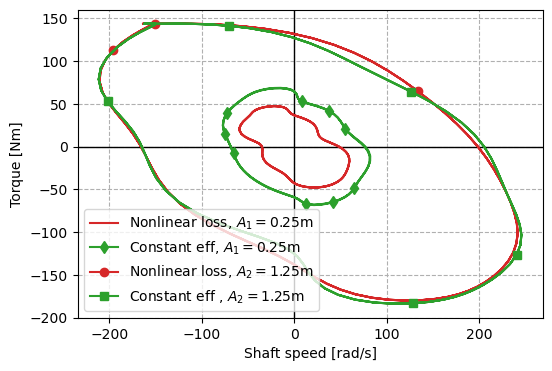

In [19]:
# FIGURE 5
fig, ax = plt.subplots(1,1,
                       figsize=(6,4))
ax.set_xlabel('Shaft speed [rad/s]')
ax.set_ylabel('Torque [Nm]')
ax.axvline(0, color='k', lw=1)
ax.axhline(0, color='k', lw=1)
ax.grid(which='major', linestyle='--')
ax.plot(np.squeeze(results_n_A1['pto_tdom'].vel.values), 
          np.squeeze(results_n_A1['pto_tdom'].force.values),
           linestyle = 'solid', color =  'C3', 
           label = f'Nonlinear loss, $A_1 = {amplitude_1:.2f}$m')
ax.plot(np.squeeze(results_c_A1['pto_tdom'].vel.values), 
          np.squeeze(results_c_A1['pto_tdom'].force.values), 
          color = 'C2',  linestyle = 'solid' , 
          label = f'Constant eff, $A_1 = {amplitude_1:.2f}$m', 
          marker ='d',markevery=30)
ax.plot(np.squeeze(results_n_A2['pto_tdom'].vel.values), 
          np.squeeze(results_n_A2['pto_tdom'].force.values),  
          linestyle = 'solid', color =  'C3', 
          label = f'Nonlinear loss, $A_2 = {amplitude_2:.2f}$m', 
          marker ='o',markevery=100)
ax.plot(np.squeeze(results_c_A2['pto_tdom'].vel.values), 
          np.squeeze(results_c_A2['pto_tdom'].force.values), color = 'C2',  
          linestyle = 'solid' , 
          label = f'Constant eff , $A_2 = {amplitude_2:.2f}$m', 
          marker ='s',markevery=60)
ax.legend()

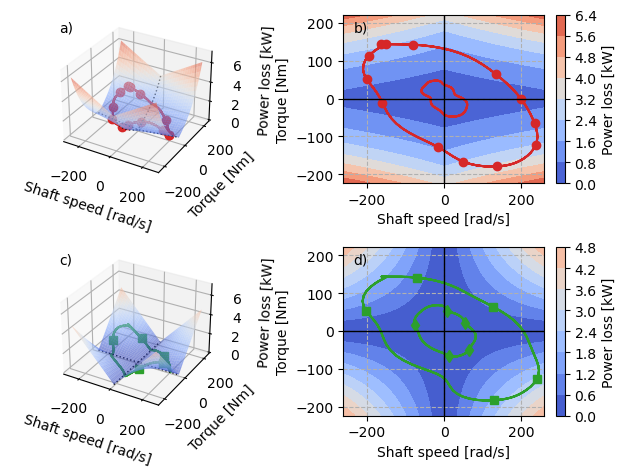

In [20]:
#FIGURE 6

rot_speed = np.arange(-0.25*rot_speed_max, .25*rot_speed_max, 5)
torque = np.arange(-0.8*torque_peak_max, 0.8*torque_peak_max, 2)
X, Y = np.meshgrid(rot_speed, torque)

Z = Ploss_interp(X, Y).copy()/1e3
Z_c = constant_Ploss_interp(X, Y).copy()/1e3

Z[np.abs(X*Y) > 80000] = np.NaN #remove entires outside poew rlimit
Z_c[np.abs(X*Y) > 80000] = np.NaN

Ploss_orb_n  = results_n_A2['pto_tdom']['power'] - results_n_A2['pto_tdom']['mech_power']
Ploss_orb_c = results_c_A2['pto_tdom']['power'] - results_c_A2['pto_tdom']['mech_power']

P_loss_max = 7    #only for plotting

fig_A, axes_A = plt.subplots(2,2)
axes_A[0,0].axis('off')
axes_A[1,0].axis('off')

axes_A[0,0] = fig_A.add_subplot(2, 2, 1, projection=Axes3D.name)
axes_A[1,0] = fig_A.add_subplot(2, 2, 3, projection=Axes3D.name)

# Plot the Ploss surface.
surf = axes_A[0,0].plot_surface(X, Y, Z, 
                       cmap=cm.coolwarm,
                       linewidth=0, alpha = 0.6,
                       vmin = 0, vmax = P_loss_max)
axes_A[0,0].set_xlabel('Shaft speed [rad/s]')
axes_A[0,0].set_ylabel('Torque [Nm]')
axes_A[0,0].set_zlabel('Power loss [kW]')
axes_A[0,0].set_zlim([0, P_loss_max])
axes_A[0,0].text2D(0.05, 0.9, "a)", transform=axes_A[0,0].transAxes)
axes_A[0,0].plot3D(np.squeeze(results_n_A2['pto_tdom'].vel.values), 
          np.squeeze(results_n_A2['pto_tdom'].force.values),
          np.squeeze(Ploss_orb_n/1e3), linestyle = 'solid',
          color =  'C3', marker ='o',markevery=20)
axes_A[0,0].plot3D(rot_speed, 
          np.zeros(rot_speed.shape),
          Ploss_interp(rot_speed, np.zeros(rot_speed.shape))/1e3,
          'black', linestyle = 'dotted', lw=1)
axes_A[0,0].plot3D(np.zeros(torque.shape), 
          torque,
          Ploss_interp(np.zeros(torque.shape), torque)/1e3,
          'black', linestyle = 'dotted', lw=1)

# Plot the ploss countour.
contour = axes_A[0,1].contourf(X, Y, Z, cmap=cm.coolwarm, vmin = 0,
                                 vmax = P_loss_max)
axes_A[0,1].plot(np.squeeze(results_n_A2['pto_tdom'].vel.values), 
          np.squeeze(results_n_A2['pto_tdom'].force.values),
            linestyle = 'solid', color =  'C3',
            label = 'Nonlinear loss map', marker ='o',markevery=20)
axes_A[0,1].plot(np.squeeze(results_n_A1['pto_tdom'].vel.values), 
          np.squeeze(results_n_A1['pto_tdom'].force.values),
          linestyle = 'solid', color =  'C3', label = 'Nonlinear loss map')
axes_A[0,1].set_xlabel('Shaft speed [rad/s]')
axes_A[0,1].set_ylabel('Torque [Nm]')
fig.colorbar(contour, label="Power loss [kW]", ax=axes_A[0,1])
axes_A[0,1].grid(which='major', linestyle='--')
axes_A[0,1].axvline(0, color='k', lw=1)
axes_A[0,1].axhline(0, color='k', lw=1)
axes_A[0,1].text(0.05, 0.9, "b)", transform=axes_A[0,1].transAxes)

# Plot the loss surface.
surf = axes_A[1,0].plot_surface(X, Y, Z_c,
                       cmap=cm.coolwarm,
                       linewidth=0, alpha = 0.6, vmin = 0, vmax = P_loss_max)
axes_A[1,0].set_xlabel('Shaft speed [rad/s]')
axes_A[1,0].set_ylabel('Torque [Nm]')
axes_A[1,0].set_zlim([0, P_loss_max])
axes_A[1,0].set_zlabel('Power loss [kW]')
axes_A[1,0].text2D(0.05, 0.90, "c)", transform=axes_A[1,0].transAxes)
axes_A[1,0].plot3D(np.squeeze(results_c_A2['pto_tdom'].vel.values), 
          np.squeeze(results_c_A2['pto_tdom'].force.values),
          np.squeeze(Ploss_orb_c/1e3), color = 'C2',
          linestyle = 'solid', marker ='s',markevery=60)
axes_A[1,0].plot3D(rot_speed, 
          np.zeros(rot_speed.shape),
          constant_Ploss_interp(rot_speed, np.zeros(rot_speed.shape))/1e3,
          'black', linestyle = 'dotted', lw=1)
axes_A[1,0].plot3D(np.zeros(torque.shape), 
          torque,
          constant_Ploss_interp(np.zeros(torque.shape), torque)/1e3,
          'black', linestyle = 'dotted', lw=1)

# Plot the electric power surface.
contour = axes_A[1,1].contourf(X, Y, Z_c, cmap=cm.coolwarm, vmin = 0,
                                 vmax = P_loss_max)
axes_A[1,1].plot(np.squeeze(results_c_A2['pto_tdom'].vel.values), 
          np.squeeze(results_c_A2['pto_tdom'].force.values),
          linestyle = 'solid', color =  'C2', label = 'Constant efficiency',
          marker ='s',markevery=60)
axes_A[1,1].plot(np.squeeze(results_c_A1['pto_tdom'].vel.values), 
          np.squeeze(results_c_A1['pto_tdom'].force.values),
          linestyle = 'solid', color =  'C2', label = 'Constant efficiency',
          marker ='d',markevery=60)
axes_A[1,1].set_xlabel('Shaft speed [rad/s]')
axes_A[1,1].set_ylabel('Torque [Nm]')
fig.colorbar(contour, label="Power loss [kW]", ax=axes_A[1,1])
axes_A[1,1].grid(which='major', linestyle='--')
axes_A[1,1].axvline(0, color='k', lw=1)
axes_A[1,1].axhline(0, color='k', lw=1)
axes_A[1,1].text(0.05, 0.90, "d)", transform=axes_A[1,1].transAxes)
plt.tight_layout()


## 3.1.1 Experiment: Exchanging control trajectories

In [21]:
x_wec_n_A1, x_opt_n_A1 = wec.decompose_state(results_n_A1['results'].x)
x_wec_c_A1, x_opt_c_A1 = wec.decompose_state(results_c_A1['results'].x)
x_wec_n_A2, x_opt_n_A2 = wec.decompose_state(results_n_A2['results'].x)
x_wec_c_A2, x_opt_c_A2 = wec.decompose_state(results_c_A2['results'].x)

In [22]:
nsubsteps = 5
Pe_n_A1 = pto_n.average_power(wec, x_wec_n_A1, x_opt_n_A1, waves_A1, nsubsteps  )
Pe_nc_A1 = pto_n.average_power(wec, x_wec_c_A1,x_opt_c_A1, waves_A1, nsubsteps  )
Pe_c_A1 = pto_c.average_power(wec, x_wec_c_A1, x_wec_c_A1, waves_A1, nsubsteps  )

Pm_n_A1 = pto_n.mechanical_average_power(wec, x_wec_n_A1, x_opt_n_A1, waves_A1, nsubsteps  )
Pm_nc_A1 = pto_n.mechanical_average_power(wec, x_wec_c_A1,x_opt_c_A1, waves_A1, nsubsteps  )
Pm_c_A1 = pto_c.mechanical_average_power(wec, x_wec_c_A1, x_opt_c_A1, waves_A1, nsubsteps  )

Pe_n_A2 = pto_n.average_power(wec, x_wec_n_A2, x_opt_n_A2, waves_A2, nsubsteps  )
Pe_nc_A2 = pto_n.average_power(wec, x_wec_c_A2, x_opt_c_A2, waves_A2, nsubsteps  )
Pe_c_A2 = pto_c.average_power(wec, x_wec_c_A2, x_opt_c_A2, waves_A2, nsubsteps  )

Pm_n_A2 = pto_n.mechanical_average_power(wec, x_wec_n_A2, x_opt_n_A2, waves_A2, nsubsteps  )
Pm_nc_A2 = pto_n.mechanical_average_power(wec, x_wec_c_A2,x_opt_c_A2, waves_A2, nsubsteps  )
Pm_c_A2 = pto_c.mechanical_average_power(wec, x_wec_c_A2, x_opt_c_A2, waves_A2, nsubsteps  )

In [23]:
print(f'Nonlinear loss: Mechanical power A1: {Pm_n_A1:.1f} W , A2: {Pm_n_A2:.1f} W,'
      f' Electrical power: A1: {Pe_n_A1:.1f} W, A2: {Pe_n_A2:.1f} W') 
print(f'Constant efficiency: Mechanical power A1: {Pm_c_A1:.1f} W, A2: {Pm_c_A2:.1f} W,'
      f' Electrical power: A1: {Pe_c_A1:.1f} W, A2: {Pe_c_A2:.1f} W') 

Nonlinear loss: Mechanical power A1: -557.3 W , A2: -11446.8 W, Electrical power: A1: -208.0 W, A2: -9593.7 W
Constant efficiency: Mechanical power A1: -674.2 W, A2: -11419.9 W, Electrical power: A1: 0.7 W, A2: -10268.9 W


In [24]:
print(f'Constant efficiency trajectory for PTO with nonlinear power loss map: '
      f' {(Pm_nc_A1/Pm_n_A1 - 1)*100:.1f} %, A2: {(Pm_nc_A2/Pm_n_A2 - 1)*100:.1f} %,'
      f' Electrical power: A1:{(Pe_nc_A1/Pe_n_A1 - 1)*100:.1f} %,, A2: {(Pe_nc_A2/Pe_n_A2 - 1)*100:.1f} %')

Constant efficiency trajectory for PTO with nonlinear power loss map:  21.0 %, A2: -0.2 %, Electrical power: A1:-27.7 %,, A2: -0.2 %


## 3.2 Time series results

In [25]:
def align_yyaxis(ax1, ax2):
    ax1_ylims = ax1.axes.get_ylim()           # Find y-axis limits set by the plotter
    ax1_yratio = ax1_ylims[0] / ax1_ylims[1]  # Calculate ratio of lowest limit to highest limit

    ax2_ylims = ax2.axes.get_ylim()           # Find y-axis limits set by the plotter
    ax2_yratio = ax2_ylims[0] / ax2_ylims[1]  # Calculate ratio of lowest limit to highest limit

    if ax1_yratio < ax2_yratio: 
        ax2.set_ylim(bottom = ax2_ylims[1]*ax1_yratio)
    else:
        ax1.set_ylim(bottom = ax1_ylims[1]*ax2_yratio)

Text(-0.2, 1, 'd)')

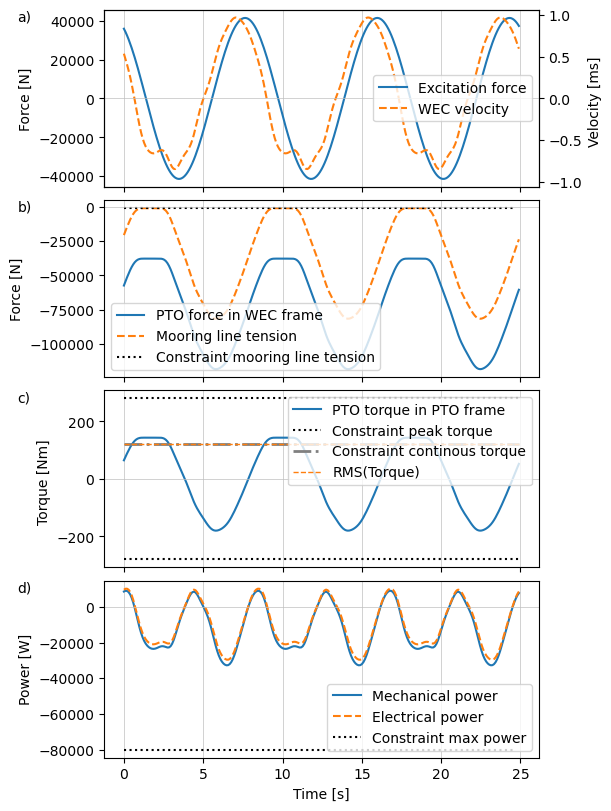

In [26]:
#FIGURE 7
fig, axes = plt.subplots(nrows=4,
                       figsize=(6,8), sharex = True,
                       constrained_layout=True)


#velocity and wave excitation force
line1 = results_n_A2['wec_tdom'].force.sel(type='Froude_Krylov').plot(ax = axes[0], label='FK force')
axes[0].set_ylabel('Force [N]')
axes[0].set_xlabel('')
axes[0].set_title('')
axes[0].text(-0.2, 1, "a)", ha="left", va="top", transform=axes[0].transAxes)

ax0r = axes[0].twinx()
line2 = results_n_A2['wec_tdom'].vel.plot(ax = ax0r, 
            label = 'WEC velocity', linestyle = 'dashed', color = 'C1')
ax0r.set_ylabel('Velocity [ms] ')
ax0r.set_title('')
ax0r.tick_params(axis='y', color='black', labelcolor='black')
align_yyaxis(axes[0],ax0r)
lines = line1 + line2  
ax0r.legend(lines, ['Excitation force','WEC velocity ', ])

plt.axhline(y=0, xmin = 0, xmax = 1, color = '0.75', linewidth=0.5)
axes[0].grid(color='0.75', linestyle='-',
                     linewidth=0.5, axis = 'x')

# #line tension and PTO force
results_n_A2['wec_tdom'].force.sel(type='PTO').plot(ax = axes[1], 
                                   label = 'PTO force in WEC frame')
axes[1].plot(wec.time_nsubsteps(nsubsteps), 
             wec.forces['PTO'](wec, x_wec_n_A2,
                                x_opt_n_A2, waves_A2, nsubsteps), 
             linestyle = 'dashed', label = 'Mooring line tension')
axes[1].plot(wec.time, min_line_tension*np.ones(wec.time.shape),
            linestyle = 'dotted', color = 'black',
            label = 'Constraint mooring line tension')
axes[1].axhline(y=0, xmin = 0, xmax = 1, color = '0.75', linewidth=0.5)
axes[1].set_title('')
axes[1].set_ylabel('Force [N]')
axes[1].legend()
axes[1].set_xlabel('')
axes[1].grid(color='0.75', linestyle='-',
                     linewidth=0.5, axis = 'x')
axes[1].text(-0.2, 1, "b)", ha="left", va="top", transform=axes[1].transAxes)

# PTO torque in PTO frame
(results_n_A2['pto_tdom'].force ).plot(ax= axes[2], 
                                        linestyle = 'solid',
                                         label = 'PTO torque in PTO frame')
axes[2].plot(results_n_A2['pto_tdom'].time, 
             1*torque_peak_max*np.ones(results_n_A2['pto_tdom'].time.shape),
             color = 'black', linestyle = 'dotted', 
             label = 'Constraint peak torque')
axes[2].plot(results_n_A2['pto_tdom'].time, 
             -1*torque_peak_max*np.ones(results_n_A2['pto_tdom'].time.shape),
              color = 'black', linestyle = 'dotted')

torque_rms = np.sqrt(np.mean(results_n_A2['pto_tdom'].force.values**2))
axes[2].plot(results_n_A2['pto_tdom'].time, 
             torque_continues_max*np.ones(results_n_A2['pto_tdom'].time.shape), 
             color = 'grey',  linewidth = '2.0', 
             linestyle = 'dashdot', label = 'Constraint continous torque')
axes[2].plot(results_n_A2['pto_tdom'].time, 
             torque_rms*np.ones(results_n_A2['pto_tdom'].time.shape),
             linestyle = 'dashed',  linewidth = '1.0',label = 'RMS(Torque)')
axes[2].grid(color='0.75', linestyle='-',
                     linewidth=0.5, axis = 'x')
axes[2].legend(loc = 'upper right',)
axes[2].set_xlabel('')
axes[2].set_ylabel('Torque [Nm] ')

axes[2].set_title('')
axes[2].axhline(y=0, xmin = 0, xmax = 1, color = '0.75', linewidth=0.5)
axes[2].text(-0.2, 1, "c)", ha="left", va="top", transform=axes[2].transAxes)

# Power
results_n_A2['pto_tdom']['mech_power'].plot(ax = axes[3], 
                                        label = 'Mechanical power')
results_n_A2['pto_tdom']['power'].plot(ax = axes[3], 
                linestyle = 'dashed', label = 'Electrical power')
axes[3].plot(wec.time, -1*power_max*np.ones(wec.time.shape),
                linestyle = 'dotted',
                color = 'black', label = 'Constraint max power')
axes[3].grid(color='0.75', linestyle='-',
                     linewidth=0.5, axis = 'x')
axes[3].legend()
axes[3].set_title('')
axes[3].axhline(y=0, xmin = 0, xmax = 1, color = '0.75', linewidth=0.5)
axes[3].text(-0.2, 1, "d)", ha="left", va="top", transform=axes[3].transAxes)

## 4 CONTROL CO-DESIGN OF MASS / LINE PRETENSION

In [27]:
global max_torque, rms_torque_ratios 
max_torque = []
rms_torque_ratios = []

def design_obj_fun(x):
    global n
    n += 1
    # Unpack geometry variables
    mass_ratio = x[0]
    mass_var = mass_ratio * max_mass
    # update WEC 
    wec_mass = wot.WEC.from_bem(
                bem_data,
                inertia_matrix= mass_var,
                hydrostatic_stiffness=stiffness,
                constraints=None,
                friction=None,
                f_add=None,
            )
    # Solve
    print(f'Run {n} off {N+1}: Mass: {mass_var}kg')
    results = solve_wrapper_function(wec_mass, pto_n, nstate_opt, 1e1*1, 1e-2, 1e-2, reg_wave)
    opt_average_power = results['results'].fun
    print(f'Mass: {mass_var}kg, Optimal average power: {opt_average_power} W')
    global max_torque 
    x_wec, x_opt = wec_mass.decompose_state(results['results'].x)
    max_torque.append(np.max(wec.forces['PTO'](wec_mass, x_wec, x_opt, reg_wave, nsubsteps)))
    rms_torque_ratios.append(np.sqrt(np.mean(pto_c.force_on_wec(wec_mass, x_wec, x_opt, reg_wave, nsubsteps)**2))/torque_continues_max)
    
    return opt_average_power

In [28]:
#find max mass (when minimum pretension is hit)
min_ten = -1000
max_mass = min_ten/g + displaced_mass_cpy
max_mass

array([[6646.86072341]])

In [29]:
#mass range over which to search
global n; n = 0 
global N; N = 7 
min_mass_ratio = 0.3
max_mass_ratio = 1
mass_vals = np.linspace(min_mass_ratio, max_mass_ratio, N, endpoint=False)
ranges = (slice(
    mass_vals[0], mass_vals[-1]+np.diff(mass_vals)[0], np.diff(mass_vals)[0]
    ),
)

### waves

In [30]:
regular_waves = []
# amplitudes = [1.25,  0.75, 0.25]
# wavefrequencies = [0.12, 0.16, 0.12]
amplitudes = [1.25,  0.75, 0.25]
wavefrequencies = [0.12, 0.16, 0.12]
for amplitude, wavefreq in zip(amplitudes, wavefrequencies):
    phase = 30
    wavedir = 0
    single_wave = wot.waves.regular_wave(f1, nfreq, 
                        wavefreq, amplitude, phase, wavedir)
    regular_waves.append(single_wave)
print(f'Wave periods {[1/wf for wf in wavefrequencies]}')

Wave periods [8.333333333333334, 6.25, 8.333333333333334]


In [31]:
res = []
for iw, reg_wave in enumerate(regular_waves):
    n = 0
    print(f"\n\Wave #: {iw+1}")
    res.append(brute(func=design_obj_fun, ranges=ranges, full_output=True,  finish=None))


\Wave #: 1
Run 1 off 8: Mass: [[1994.05821702]]kg
Optimization terminated successfully    (Exit mode 0)
            Current function value: -96.53721126344182
            Iterations: 89
            Function evaluations: 298
            Gradient evaluations: 89
Mass: [[1994.05821702]]kg, Optimal average power: -9653.721126344182 W
Run 2 off 8: Mass: [[2658.74428936]]kg
Optimization terminated successfully    (Exit mode 0)
            Current function value: -96.93667039062211
            Iterations: 48
            Function evaluations: 90
            Gradient evaluations: 48
Mass: [[2658.74428936]]kg, Optimal average power: -9693.667039062211 W
Run 3 off 8: Mass: [[3323.43036171]]kg
Optimization terminated successfully    (Exit mode 0)
            Current function value: -93.36516127681955
            Iterations: 39
            Function evaluations: 72
            Gradient evaluations: 39
Mass: [[3323.43036171]]kg, Optimal average power: -9336.516127681954 W
Run 4 off 8: Mass: [[3988.1

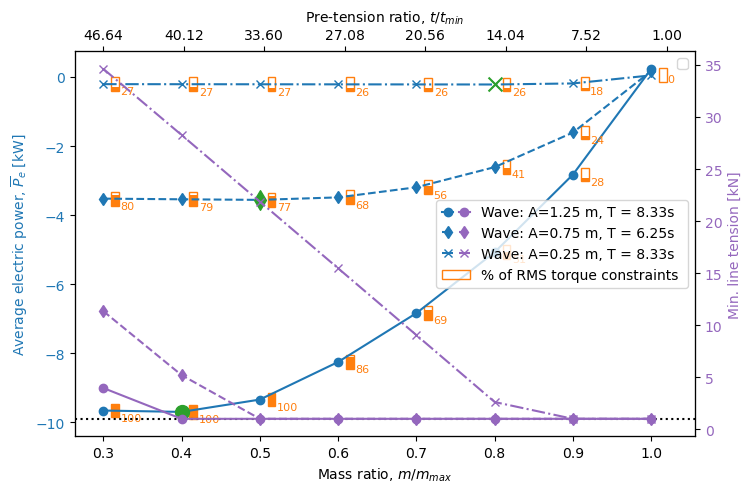

In [32]:
#FIGURE 8
from matplotlib.legend_handler import HandlerTuple
# import matplotlib.patches as ptch

lnstls = ["-","--","-.",":"]
mrkstls = ['o','d','x','^']
lns_Pe = ax.plot()
lns_T = ax.plot()

fig, ax = plt.subplots(figsize=(8,5))
for ir, individ_res in enumerate(res):
    ln = ax.plot(individ_res[2], individ_res[3]/1e3, 'C0',
     label = f'Wave: A={amplitudes[ir]} m, '
             f'T = {1/wavefrequencies[ir]:.2f}s ',
     linestyle = lnstls[ir], marker = mrkstls[ir])
    lns_Pe = lns_Pe + ln
    ax.scatter(individ_res[0], individ_res[1]/1e3, c='C2', zorder=50,
     s=100, marker = mrkstls[ir]) #optimum
    [(ax.text(x+0.022,y-0.3, f'{r*100:.0f}', color = 'C1', fontsize=8),
      ax.add_patch(plt.Rectangle((x+0.01,y-0.2), 0.01, 0.4, 
                        fc='none', ec='C1', lw=1, clip_on=False)),
      ax.add_patch(plt.Rectangle((x+0.01,y-0.2), 0.01, r*0.4, 
                    fc='C1', ec='None', lw=1, clip_on=False,)))
        for x,y,r in 
        zip(individ_res[2][0:-1], 
            individ_res[3][0:-1]/1e3, 
            rms_torque_ratios[(N+1)*(ir):(N+1)*(ir+1)][0:-1]/kinematics[0])]
ax.set_xlabel("Mass ratio, $m/m_{max}$")
ax.set_ylabel("Average electric power, $\overline{P}_e$ [kW]",
              color="C0")
ax.tick_params(axis='y', labelcolor="C0")

# second tick
new_tick_locations = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
def tick_function(x):
    mass = np.array(x) * max_mass 
    pretension_ratio = (-1*g*(displaced_mass_cpy - mass)
                         / min_line_tension )
    return [f"{tr:.2f}" for tr in np.squeeze(pretension_ratio)]
    
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(tick_function(new_tick_locations))
ax2.set_xlabel("Pre-tension ratio, $t/t_{min}$")
plt.legend()

ax3 = ax.twinx()
ln_ten = ax3.axhline(-1*min_line_tension/1e3, linestyle='dotted', color='black',
            label='Min. line tension')
for ir, individ_res in enumerate(res):
    ln =ax3.plot(individ_res[2], np.abs(max_torque[(N+1)*(ir):(N+1)*(ir+1)])/1e3, 
                 'C4',linestyle = lnstls[ir], marker = mrkstls[ir] )   
    lns_T = lns_T + ln
ax3.set_ylabel("Min. line tension [kN]", color="C4")
ax3.tick_params(axis='y', labelcolor="C4")

#add last patch manually to avoid overlap and for legend entry
ptch = ax.add_patch(plt.Rectangle((individ_res[2][-1]+0.01,individ_res[3][-1]/1e3-0.2), 0.01, 0.4, 
                fc='none', ec='C1', lw=1, clip_on=False))
ax.text(individ_res[2][-1]+0.02,individ_res[3][-1]/1e3-0.2, 
        f'{rms_torque_ratios[-1]/kinematics[0][0]*100:.0f}', color = 'C1', fontsize=8)


labs = [l.get_label() for l in (lns_Pe)]
lns_com = [(l_Pe, l_T) for l_Pe,l_T in zip(lns_Pe, lns_T )]

lns_com.append(ptch)
labs.append('% of RMS torque constraints ')

plt.legend(lns_com, labs, numpoints=1, 
          handler_map={tuple: HandlerTuple(ndivide=None)}, loc = 'right')

### Re-run optimal cases

In [33]:
res_opt = []
pto_tdom_opt = []
wec_tdom_opt = []

for individ_res, (index, reg_wave) in zip(res, enumerate(regular_waves)):
    opt_mass = individ_res[0]

    wec_opt = wot.WEC.from_bem(
            bem_data,
            inertia_matrix= opt_mass,
            hydrostatic_stiffness=stiffness,
            constraints=None,
            friction=None,
            f_add=None,
        )
    
    res_temp = solve_wrapper_function(wec_opt, pto_n, nstate_opt, 1e1*1, 1e-2, 1e-2, reg_wave)

    res_opt.append(res_temp)
    opt_average_power = res_temp['results'].fun
    print(f'Mass ratio: {opt_mass}, Optimal average power: {opt_average_power} W') 

    pto_tdom_opt.append(res_temp['pto_tdom'])

    # compare to no lower harmonics
    x_wec_opt, x_opt_opt = wec_opt.decompose_state(res_temp['results'].x,)
    Pe_n = pto_n.average_power(wec_opt, x_wec_opt, x_opt_opt, reg_wave, nsubsteps)

    #remove low frequency harmonics
    freq_R_I = np.sort(np.concatenate([freq, freq]))    
    mask_low_harm = (freq_R_I < wavefrequencies[index])
    mask_low_harm = np.insert(mask_low_harm, 0, True)   #add zero frequency
    x_wec_no_harm = x_wec_opt
    x_wec_no_harm[mask_low_harm] = 0
    x_opt_no_harm = x_opt_opt
    x_opt_no_harm[mask_low_harm] = 0
    Pe_n_no_harm = pto_n.average_power(wec_opt, x_wec_no_harm,
                                    x_opt_no_harm, reg_wave, nsubsteps  )
    print(f'Pe_n: {Pe_n:.3f} W, P_n_no_harmonics: {Pe_n_no_harm:.3f} W'
        f' ratio: {Pe_n_no_harm/Pe_n}') 


Optimization terminated successfully    (Exit mode 0)
            Current function value: -94.54751223015155
            Iterations: 69
            Function evaluations: 153
            Gradient evaluations: 69
Mass ratio: 0.39999999999999997, Optimal average power: -9454.751223015155 W
Pe_n: -9450.498 W, P_n_no_harmonics: -9450.498 W ratio: 1.0000000000018523
Optimization terminated successfully    (Exit mode 0)
            Current function value: -34.63015811420283
            Iterations: 65
            Function evaluations: 135
            Gradient evaluations: 65
Mass ratio: 0.49999999999999994, Optimal average power: -3463.0158114202827 W
Pe_n: -3454.833 W, P_n_no_harmonics: -3456.272 W ratio: 1.0004163962171235
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2.0192502998331934
            Iterations: 80
            Function evaluations: 209
            Gradient evaluations: 80
Mass ratio: 0.7999999999999998, Optimal average power: -201.9

Text(0, 0.5, 'Torque [Nm]')

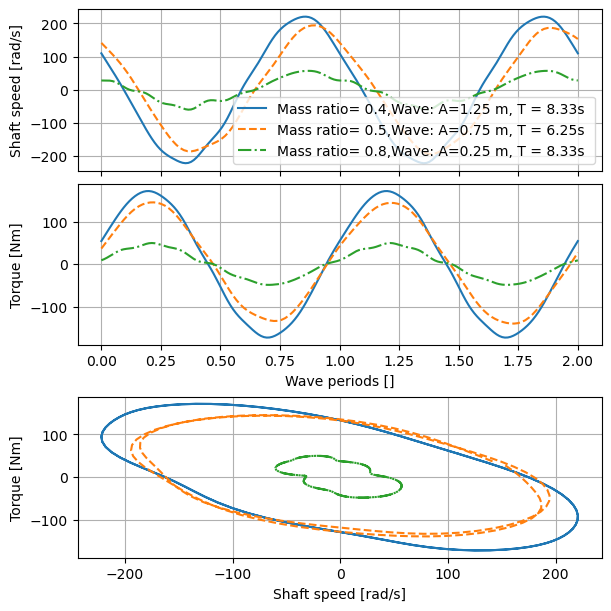

In [34]:
#FIGURE 9
fig, axes = plt.subplots(nrows = 3, figsize=(6,6), sharex = False,
                       constrained_layout=True)
lnstls = ["-","--","-.",":"]
for individ_res, pto_tdom, (index, reg_wave) in zip(res, 
                                pto_tdom_opt, enumerate(regular_waves)):
    opt_mass = individ_res[0]
    time = pto_tdom.time
    periods = 2
    mask = time <= periods/wavefrequencies[index]
    axes[0].plot(periods*time[mask]/time[mask][-1], 
            pto_tdom['vel'].values[mask], 
            linestyle = lnstls[index],
            label = f'Mass ratio= {opt_mass:.1f},'
                    f'Wave: A={amplitudes[index]} m,'
                    f' T = {1/wavefrequencies[index]:.2f}s ')
    axes[1].plot(periods*time[mask]/time[mask][-1],
            pto_tdom['force'].values[mask], 
            linestyle = lnstls[index],
            label = f'Mass ratio= {opt_mass:.1f}, '
                    f'Wave: A={amplitudes[index]} m, ' 
                    f'T = {1/wavefrequencies[index]:.2f}s ')
    axes[2].plot(pto_tdom['vel'].values[mask], 
            pto_tdom['force'].values[mask], 
            linestyle = lnstls[index],
            label = f'Mass= {opt_mass:.0f}, ' 
                    f'Wave: A={amplitudes[index]} m, '
                    f'T = {1/wavefrequencies[index]:.2f}s ')

axes[0].grid('on')
axes[0].legend()
axes[0].set_title('')
axes[0].set_ylabel('Shaft speed [rad/s]')
axes[0].set_xticklabels([])

axes[1].grid('on')
axes[1].set_title('')
axes[1].set_ylabel('Torque [Nm]')
axes[1].set_xlabel('Wave periods []')

axes[2].grid('on')
axes[2].set_title('')
axes[2].set_xlabel('Shaft speed [rad/s]')
axes[2].set_ylabel('Torque [Nm]')